# What is the relationship between Zoning and Transit Use per US Census

Steps for Analysis
1. Load the affected areas (h/t Sasha) 
2. Load the zoning areas 
3. Load the Census Tracts 
4. Join DataFrame with Census Tracts, Affected Areas and Parcels 
5. Load Census Data, normalize 
6. Compute "ChangeScore"
7. Determine Relationship 

## Source Data
* [US Census Blocks, CA](https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html) 

In [1]:
import pandas as pd
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
## Affected Areas
# Parse the shapes from Sasha's map

import json
import shapely.geometry

# convert the shapes used by the webapp to shapely shapes
def webappToShape (shp):
    return shapely.geometry.shape({
        'type': 'MultiPolygon',
        'coordinates': [[[[ll['lng'], ll['lat']] for ll in poly]] for poly in shp]
    })

# Load SB 827 data
with open('../../upzone-california/data/low_rise_shape.json') as lowRiseFd:
    lowRise = webappToShape(json.load(lowRiseFd))

with open('../../upzone-california/data/high_rise_shape.json') as highRiseFd:
    highRise = webappToShape(json.load(highRiseFd)).buffer(1e-8)

affectedArea = lowRise.union(highRise)


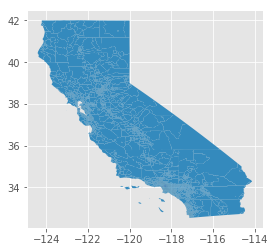

In [3]:
## Census Tracs 
census_tracts = gpd.read_file('../data/cb_2016_06_tract_500k/cb_2016_06_tract_500k.shp')
census_tracts.plot()

In [24]:
## Zoning Affected 
enriched = gpd.read_file('../data/enriched.geo.json')
enriched.head(5)

,nh,dh,ct,zn,zp,zd,zh,geometry
0,45.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,"POLYGON ((-121.9094202832327 37.3716361135314,..."
1,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,POLYGON ((-121.9173055362167 37.37697169680511...
2,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,"POLYGON ((-121.9167140425162 37.3764636035302,..."
3,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,POLYGON ((-121.9178789922728 37.37724185949239...
4,NaN,NaN,1400000US06085504314,None,NaN,NaN,NaN,"POLYGON ((-121.8518587036548 37.4056524988482,..."


* zn: zone name
* zh: zone height limit
* zp: zone mininum parking per unit
* zd: zone maximum density per acre
* nh: minimum height maximum under SB827
* dh: delta height under SB827

In [52]:
from util import get_dataframe, get_data

In [53]:
enriched['ct_strip'] = enriched['ct'].str[9:]
census_prefix = '14000US'
enriched['geoid'] = enriched['ct_strip'].apply(lambda x: census_prefix + str(x))
del(enriched['ct_strip'])

In [57]:
lookup_list = enriched['geoid'].unique()[0:10]
raw_data = [get_dataframe(tables=['B08301'], geoids = [l],col_names=True) for l in lookup_list]
affected_tracts_with_data = pd.concat(raw_data)
affected_tracts_with_data.head()

### Compute `Changescore` 

Changescore is made up of three variables - height change, resident density change and parking change average for normalized by area in a census tract. 


In [125]:
## Compute `Changescore` 

census_parcel_groups = enriched.groupby(['geoid'])

from sklearn import preprocessing

census_parcel_groups_mean = census_parcel_groups.mean().dropna()
min_max_scaler = preprocessing.MinMaxScaler()
census_parcel_groups_mean['dh_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['dh'].reshape(-1, 1))
census_parcel_groups_mean['zd_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['zd'].reshape(-1, 1))
census_parcel_groups_mean['zp_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['zp'].reshape(-1, 1))

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


In [134]:
changescores = census_parcel_groups_mean['dh_normalized'] + \
               census_parcel_groups_mean['zd_normalized'] + \
               census_parcel_groups_mean['zp_normalized']

In [161]:
change_df = pd.DataFrame({"changescores": changescores, 
                          "normalized": min_max_scaler.fit_transform(changescores.values.reshape(-1,1)).tolist()})
change_df["normalized"] = change_df['normalized'].apply(lambda x: x[0])
change_df.describe()

,changescores,normalized
count,1.311000e+03,1311.000000
mean,1.044698e+00,0.626819
std,2.501151e-01,0.150069
min,1.160237e-07,0.000000
25%,9.345263e-01,0.560716
50%,1.042369e+00,0.625421
75%,1.142492e+00,0.685495
max,1.666667e+00,1.000000


,changescores,normalized
count,1.311000e+03,1311.000000
mean,1.044698e+00,0.626819
std,2.501151e-01,0.150069
min,1.160237e-07,0.000000
25%,9.345263e-01,0.560716
50%,1.042369e+00,0.625421
75%,1.142492e+00,0.685495
max,1.666667e+00,1.000000
